# Major Question: How much does parental behaviors/impact result in Youth's usage of substances
For the binary classification, I wanted to ask how much parental behaviors impact Youth's usage of alcohol. \
For this, I utilized the below sets of data.

#### Target
- 'ALCFLAG': This is a flag for whether the youth have ever used alcohol or not.

#### Features
- 'PARCHKHW': 'ParentChecksHomework',
- 'PARHLPHW': 'ParentHelpsHomework',
- 'PRCHORE2': 'ParentAssignsChores',
- 'PRLMTTV2': 'ParentLimitsTV',
- 'PARLMTSN': 'ParentLimitsSchoolNightOutings',
- 'PRGDJOB2': 'ParentGivesPraise',
- 'PRPROUD2': 'ParentExpressesPride',
- 'ARGUPAR': 'FrequentArgumentsWithParent',
- 'PRPKCIG2': 'ParentOpinionCigarettes',
- 'PRMJEVR2': 'ParentOpinionMarijuana',
- 'PRALDLY2': 'ParentOpinionAlcoholDaily'


# Imports


In [26]:
import pandas as pd
import numpy as np

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [39]:
# Load the dataset
df = pd.read_csv('../data/youth_data.csv')
df.head()

,IRALCFY,IRMJFY,IRCIGFM,IRSMKLSS30N,IRALCFM,IRMJFM,IRCIGAGE,IRSMKLSSTRY,IRALCAGE,IRMJAGE,...,EDUSCHLGO,EDUSCHGRD2,EDUSKPCOM,IMOTHER,IFATHER,INCOME,GOVTPROG,POVERTY3,PDEN10,COUTYP4
0,991,991,91.0,91,91.0,91.0,991,991,991,991,...,1,3,0,1,1,2,2,1,2,2
1,991,60,91.0,91,91.0,2.0,991,991,991,14,...,1,6,0,1,1,2,2,1,2,2
2,1,991,91.0,91,93.0,91.0,991,991,11,991,...,1,2,1,1,1,4,2,3,1,1
3,991,991,91.0,91,91.0,91.0,991,991,991,991,...,1,2,0,1,1,3,2,2,1,1
4,991,991,91.0,91,91.0,91.0,991,991,991,991,...,1,5,0,1,1,4,2,3,2,2


### 1. Decision Trees

In [ ]:
# Mappings
target_mapping = {
    'ALCFLAG': 'EverUsedALC'
}

feature_mapping = {
    'PARCHKHW': 'ParentChecksHomework',
    'PARHLPHW': 'ParentHelpsHomework',
    'PRCHORE2': 'ParentAssignsChores',
    'PRLMTTV2': 'ParentLimitsTV',
    'PARLMTSN': 'ParentLimitsSchoolNightOutings',
    'PRGDJOB2': 'ParentGivesPraise',
    'PRPROUD2': 'ParentExpressesPride',
    'ARGUPAR': 'FrequentArgumentsWithParent',
    'PRPKCIG2': 'ParentOpinionCigarettes',
    'PRMJEVR2': 'ParentOpinionMarijuana',
    'PRALDLY2': 'ParentOpinionAlcoholDaily'
}

# Combine all mappings
column_mapping = {**target_mapping, **feature_mapping}
selected_columns = list(column_mapping.keys())

df_subset = df[selected_columns].rename(columns=column_mapping)

# Split predictors and target
df_subset['EverUsedALC'] = df_subset['EverUsedALC']
X = df_subset.drop(columns='EverUsedALC')
y = df_subset['EverUsedALC']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)

In [42]:
print(y.value_counts())
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

EverUsedALC
0    8157
1    2404
Name: count, dtype: int64
[[2356   92]
 [ 592  129]]
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      2448
           1       0.58      0.18      0.27       721

    accuracy                           0.78      3169
   macro avg       0.69      0.57      0.57      3169
weighted avg       0.75      0.78      0.74      3169



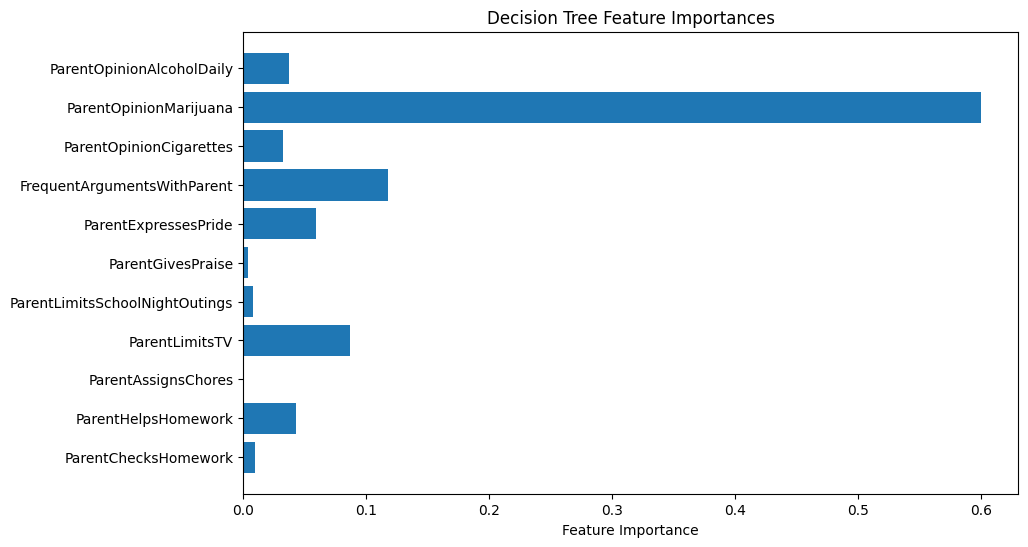

In [15]:
import matplotlib.pyplot as plt

importances = clf.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Decision Tree Feature Importances")
plt.show()

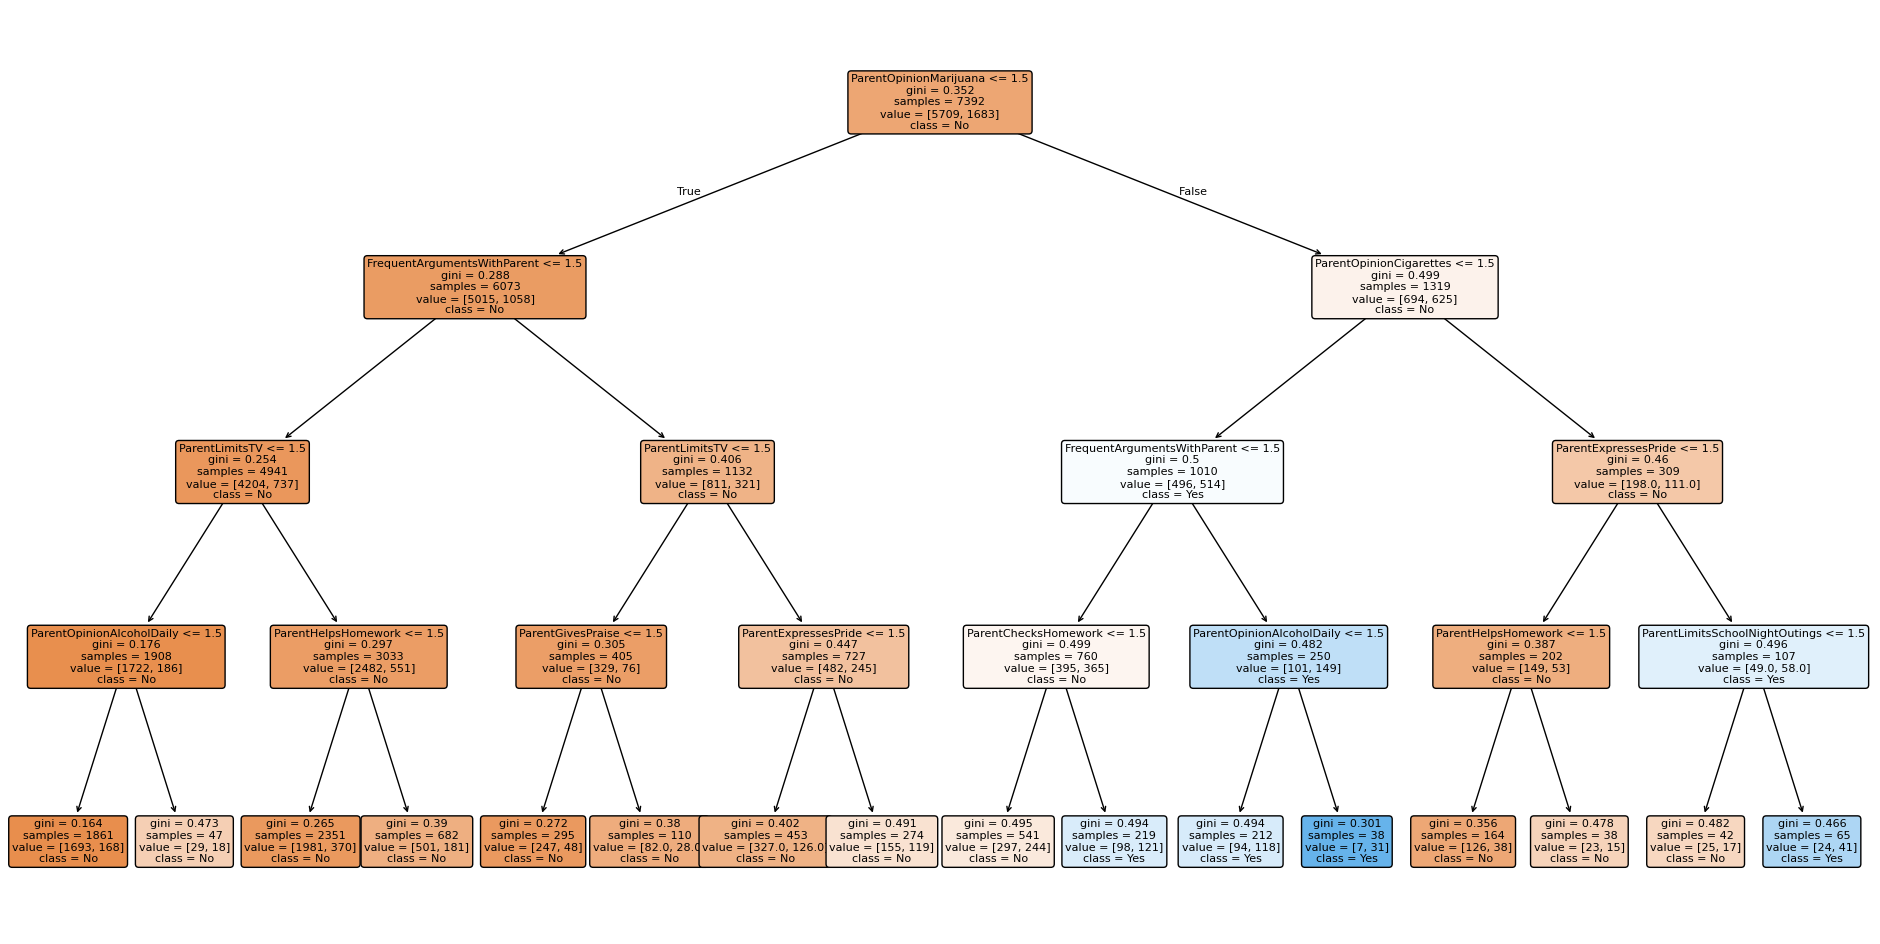

In [36]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 12))  # Wider and taller figure
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=['No', 'Yes'],
    filled=True,
    rounded=True,
    fontsize=8  # Increase font size here
)
plt.show()

## Brief Analysis
Overall Accuracy: 78%

We know that there is a class imbalance present, where the No(0) vs Yes(1) is quite disproportionate. 8157 vs 2404.

Model is more biased toward class 0 (Never had alcohol).
- Precision: 80%
- Recall: 96%
- F1-score: 0.87

For class 1:
- Precision: 58%
- Recall: 18%
- F1-score: 0.27

Thus, due to the class imbalance issue, it's reasonable to see that most users are in class 0 as model defaults to "No" often.

### 2. Random Forest

In [ ]:
# Random Forest
rf = RandomForestClassifier(random_state=42)

# Parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Parameters: {'max_depth': 4, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      2448
           1       0.64      0.18      0.28       721

    accuracy                           0.79      3169
   macro avg       0.72      0.57      0.58      3169
weighted avg       0.76      0.79      0.74      3169



In [33]:
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

[[2377   71]
 [ 594  127]]
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      2448
           1       0.64      0.18      0.28       721

    accuracy                           0.79      3169
   macro avg       0.72      0.57      0.58      3169
weighted avg       0.76      0.79      0.74      3169



## Brief Analysis
Overall Accuracy: 79%

We know that there is a class imbalance present, where the No(0) vs Yes(1) is quite disproportionate. 8157 vs 2404.

Model is more biased toward class 0 (Never had alcohol).
- Precision: 80%
- Recall: 96%
- F1-score: 0.87

For class 1:
- Precision: 64%
- Recall: 18%
- F1-score: 0.28

There is a slight improvement from the regular decision tree.

# Bagging

In [38]:
# Base estimator: shallow decision tree
base_dt = DecisionTreeClassifier(random_state=42)

# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.6, 0.8, 1.0],
    'estimator__max_depth': [3, 4, 5],
}

# Bagging classifier with base decision tree
bagging = BaggingClassifier(
    estimator=base_dt,
    random_state=42,
    n_jobs=-1
)

# Grid search with 5-fold CV
grid_search = GridSearchCV(
    bagging,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best model and results
print("Best Params:", grid_search.best_params_)
print("Best Cross-Validated F1 Score:", grid_search.best_score_)

# Use best estimator to predict test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Final evaluation
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Params: {'estimator__max_depth': 5, 'max_samples': 1.0, 'n_estimators': 50}
Best Cross-Validated F1 Score: 0.27652130435021977
[[2364   84]
 [ 595  126]]
              precision    recall  f1-score   support

           0       0.80      0.97      0.87      2448
           1       0.60      0.17      0.27       721

    accuracy                           0.79      3169
   macro avg       0.70      0.57      0.57      3169
weighted avg       0.75      0.79      0.74      3169



## Brief Analysis
Overall Accuracy: 79%

We know that there is a class imbalance present, where the No(0) vs Yes(1) is quite disproportionate. 8157 vs 2404.

Model is more biased toward class 0 (Never had alcohol).
- Precision: 80%
- Recall: 97%
- F1-score: 0.87

For class 1:
- Precision: 60%
- Recall: 17%
- F1-score: 0.27

Much like the random forest, there is a slight increase in model confidence compared to the DT. However, does not beat the RF.